# Quantum Algorithms using QSVT
As of today, there are roughly three big classes of quantum algorithms which are believed to bring a computational advantage over classical computers and form the basis of many other popular quantum algorihtms: phase estimation, unstructured search, and Hamiltonian simulation. While they seem to have not much in common, it turned out that they can actually be unified through a mathematical framework called the quantum singular value transformation (QSVT). The fact that these seemingly unrelated algorithms can all be derived from the QSVT has led to the believe that other algorithms could be derived from it as well. 
This notebook is primarily based on the Grand Unification paper [[1]](#grand_unification).

In essence, QSVT transforms all the singular values of a block-encoded input matrix by some polynomial function that can be defined beforehand through a set of phase angles. QSVT combines the idea of quantum signal processing (QSP), which applies a polynomial transformation to one input value, and a technique called qubitization to extend it to a higher-dimensional setup.

In [29]:
from qiskit import *
from qiskit import Aer

from qiskit.circuit.library.standard_gates import XGate, MCXGate
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.opflow import I, X, PrimitiveOp

import numpy as np
from scipy.linalg import expm, sinm, cosm, sqrtm
import matplotlib.pyplot as plt

# custom utility functions
from util import *

# Quantum Signal Processing
QSP is essentially an alternating sequence of two different operations:

The **signal rotation operator** is defined as follows for a fixed input signal $a \in [-1,1]$:
$$
W(a) = 
\begin{bmatrix}
a & i\sqrt{1-a^2} \\
i\sqrt{1-a^2} & a
\end{bmatrix}
$$
In the Bloch sphere, it can be seen as an x rotation by angle $\theta = -2 \cdot \arccos(a)$.

In [30]:
def W(a):
    """
    signal rotation operator
    """
    return np.array([[a, 1j*np.sqrt(1-np.square(a)+0j)], [1j*np.sqrt(1-np.square(a)+0j), a]], dtype = 'complex_')

The **signal-processing rotation operator** is defined as:
$$
S(\phi) = e^{i \phi Z}
=
\begin{bmatrix}
e^{i\phi} & 0 \\
0 & e^{-i\phi}
\end{bmatrix}
$$
This is really just a z rotation by angle $-2\phi$. Each signal-processing rotation operator is parameterized by a phase angle $\phi_k$

In [31]:
def S(phi):
    """
    signal processing operator
    """
    return expm(1j*phi*Z_gate)

The repeated alternating multiplication of these operators results in a polynomial transformation of $a$ in the top-left entry (we don't really care about the other entries).
$$
U_{\vec{\phi}} = e^{i \phi_0 Z} \prod_{k=1}^d W(a) e^{i \phi_k Z}
=
\begin{bmatrix}
P(a) & i Q(a) \sqrt{1-a^1} \\
i Q^{*}(a) \sqrt{1-a^2} & P^{*}(a)
\end{bmatrix}
$$
The intuition behind this is that with every multiplication of the signal rotation operator, we increase the degree of the polynomial, and by interleaving it with the signal-processing rotation operator, we can influence the coefficients of the polynomial [[3]](#pennylane_tutorial).

<img src="./images/QSP_circuit.svg" alt="QSP circuit" width=30%>

In [32]:
def QSP(phi_vec, a):
    """
    input: vector of phis, a
    Performs the quantum signal processing 
    """
    result = S(phi_vec[0])
    for k in range(1, len(phi_vec)):
        result = result @ (W(a) @ S(phi_vec[k]))
    return result

For a given vector of phase angles $\vec{\phi} \in \mathbb{R}^{d+1}$ and an input signal $a \in [-1,1]$, there exist complex polynomials $P(a)$ and $Q(a)$ such that:
1. $deg(P) \le d$ and $deg(Q) \le d -1$
2. $P$ has parity $d \mod 2$ and $Q$ has parity $d-1 \mod 2$
3. $|P|^2 + (1-a^2) |Q|^2 = 1$

Interestingly, the converse is also true and we can find corresponding phase angles for any polynomial that obeys the above mentioned restrictions. In fact, there are methods to determine those phase angles automatically  [[4]](#qsp_angles).

## Trivial Example
Let us consider the example of $\vec{\phi} = (0,0)$:
$$
U_{\vec{\phi}}
=
\begin{bmatrix}
a & i\sqrt{1-a^2} \\
i\sqrt{1-a^2} & a
\end{bmatrix}
\cdot
\begin{bmatrix}
a & i\sqrt{1-a^2} \\
i\sqrt{1-a^2} & a
\end{bmatrix}
=
\begin{bmatrix}
2a^2-1 & 2ai\sqrt{1-a^2} \\
2ai\sqrt{1-a^2} & 2a^2-1
\end{bmatrix}
$$

$$
\left< 0 \middle| U_{\vec{\phi}} \middle| 0 \right> = 2a^2-1
$$

## BB1 Example
The BB1 pulse sequence is originally magnetic resonance imaging to increase image contrast. It is defined by the following phase angles:
$ \vec{\phi} = (\pi/2, -\eta, 2\eta, 0, -2\eta, \eta) $ with $ \eta = \frac{1}{2} \cdot \arccos(-\frac14) $.
If we plot the probability $p = |\braket{0 | U_{\vec{\phi}} | 0}|^2$, we can see that with very high probability, the state $\ket{0}$ remains unchanged for a wide range of iniput signals.

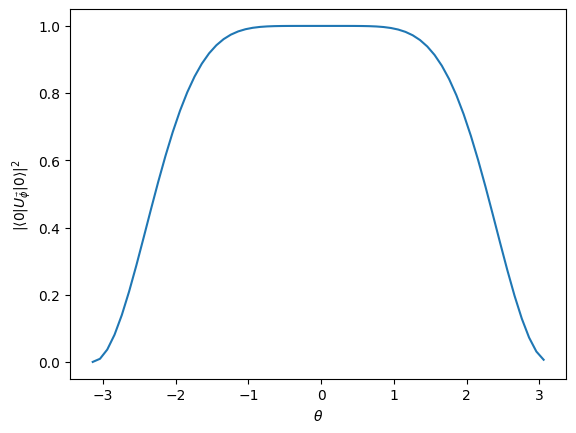

In [33]:
eta = 1/2 * np.arccos(-1/4)
phi_vec_bb1 = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]

theta_vec = np.arange(start=-np.pi, stop=np.pi, step=0.1)
a_vec = [np.cos(-1/2*theta) for theta in theta_vec]

p = [np.square(np.abs(QSP(phi_vec_bb1, a)[0][0])) for a in a_vec]

plt.plot(theta_vec, p)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$| \langle 0| U_{\vec{\phi}} |0 \rangle |^2$")
plt.show()

# Extension to multi-qubit case
As a next step, instead of transforming just one scalar, we want to polynomially transform a whole matrix.

## Block-encoding
The first problem we need to solve is that a general matrix is not necessarily unitary which is required in order for it to be considered a quantum operator. To circumvent this issue, we can just block-encode this matrix inside a larger matrix $U$ which will be unitary.
$$
U =
\begin{bmatrix}
A & \cdot \\
\cdot & \cdot
\end{bmatrix}
$$
Finding a block-encoding for a general matrix is not a trivial task. However, if $A$ is a square matrix, we can use the following block-encoding:
$$
U
=
\begin{bmatrix}
A & \sqrt{I - A^2} \\
\sqrt{I - A^2} & -A
\end{bmatrix}
$$

In [34]:
def block_encode(H):
    """
    returns a block-encoding for a Hermitian matrix H
    """
    return np.kron(Z_gate, H) + np.kron(X_gate, sqrtm(np.eye(H.shape[0]) - H @ H))

## Generalization of the signal-processing rotation operator
Any matrix $A$ can be decomposed into $A = U \Sigma V^*$ where $\Sigma$ is a diagonal matrix containing the singular values of $A$. This process is called the singular value decomposition (SVD). Transforming a matrix is equivalent to just transform all of its singular values in the SVD decomposition. Therefore, if we want to extend QSP to the higher-dimensional case, we need to apply the phase $e^{i\phi}$ to all of the singular values of the block-encoded matrix. We do that by introducing a so called **projector-controlled phase gate**:
$$
\Pi_{\phi} = e^{i\phi (2 \Pi - I)}
$$
In a quantum circuit, $\Pi_{\phi}$ is implemented using the standard single-qubit signal-processing rotation operator wrapped by two projector-controlled NOT-gates, which apply an $X$ gate on the auxiliary qubit if the projector qubits are in the desired state.

<img src="./images/projector-controlled_phase_gate.svg" alt="projector-controlled phase gate circuit" width=15%>

We can use the same phase angles as for the QSP but only need to substract a phase difference.

In [35]:
def phase_diff(d):
    """
    Calculates the phase difference between QSP and QSVT phase angles
    """
    return np.array([np.pi/4] + (d-1)*[np.pi/2] + [np.pi/4])

# Quantum Eigenvalue Transformation
Before we come to the more general QSVT, let us first look at the quantum eigenvalue transformation (QEVT), which is a special case of the QSVT. We can use the QEVT if we want to transform a Hermitian matrix $\mathcal{H}$ instead of a general matrix.
In the case that we use the block-encoding as defined above, i.e. we only have one auxiliary qubit, we can access our matrix within the block-encoding using the projector $\Pi = \ket{0}\bra{0}$. Thus, the projector-controlled phase gate becomes:

<img src="./images/projector-controlled_phase_gate_one_aux_qubit.svg" alt="circuit ofprojector-controlled phase gate acting on one auxiliary qubit" width=15%>

Putting it all together we arrive at:

$$
\begin{align*}
U_{\vec{\phi}}^{(QEVT)}
&=
\begin{cases}
\begin{aligned}
\left[ \prod_{k=1}^{d/2} \Pi_{\phi_{2k-1}} U^{\dagger} \Pi_{\phi_{2k}} U \right]
\end{aligned}
& \text{for $d$ even}
\\[20pt]
\begin{aligned}
\Pi_{\phi_1} U \left[ \prod_{k=1}^{(d-1)/2} \Pi_{\phi_{2k}} U^{\dagger} \Pi_{\phi_{2k+1}} U \right]
\end{aligned}
& \text{for $d$ odd}
\end{cases}
\\[40pt]
&=
\begin{bmatrix}
\textrm{Poly}(A) & \cdot \\
\cdot & \cdot
\end{bmatrix}
\end{align*}
$$

Since any Hermitian matrix is equal to its adjoint by definition, we no longer have to alternate between the two cases and can simplify the calculation to:
$$
U_{\vec{\phi}}^{(QEVT)}
=
\Pi_{\phi_0} \prod_{k=1}^{d} U \Pi_{\phi_{k}}
$$

In [36]:
def QEVT(phi_vec, H):
    """
    Performs the quantum eigenvalue transformation for a matrix H
    """
    assert H.shape[0] == H.shape[1], "QEVT only supports square matrices"

    U = block_encode(H)

    dim = H.shape[0]
    d = len(phi_vec)

    result = np.kron(expm(1j*phi_vec[0]*Z_gate), np.eye(dim))

    for k in range(1, d):
        result = result @ (U @ np.kron(expm(1j*phi_vec[k]*Z_gate), np.eye(dim)))
    
    return result

The overall circuit model for QEVT looks like this:

<img src="./images/QEVT_circuit.svg" alt="circuit of the QEVT" width=50%>

Using the fact that $e^{i\phi (2\ket{0}\bra{0} - I)} = e^{i\phi Z}$, we can simplify this to:

<img src="./images/QEVT_circuit_simplified.svg" alt="simplified circuit of the QEVT" width=30%>

## Example: Eigenstate filtering
One very natural application of the QEVT is eigenstate filtering where the goal is to filter out all the eigenvalues that lie above a certain threshold.
As an example, consider the following Hamiltonian:
$$\mathcal{H} = \frac{1}{10} \cdot Z_1 \otimes Y_2 \otimes Z_3 + \frac25 \cdot X_1 \otimes Y_2 \otimes Y_3 - \frac15 \cdot Y_1 \otimes Y_2 \otimes Y_3 + \frac{1}{20} \cdot I_1 \otimes Z_2 \otimes X_3 + \frac{9}{20} \cdot I_1 \otimes I_2 \otimes I_3$$

In [37]:
H = 0.1 * np.kron(Z_gate, np.kron(Y_gate, Y_gate)) + 0.4 * np.kron(X_gate, np.kron(Y_gate, Y_gate)) - 0.2 * np.kron(Y_gate, np.kron(Y_gate, Y_gate)) + 0.05 * np.kron(np.eye(2), np.kron(Z_gate, X_gate)) + 0.45 * np.kron(np.eye(2), np.kron(np.eye(2), np.eye(2)))

# norm of Hamiltonian mus be smaller than 1
H = H / (1.25 * np.linalg.norm(H))
np.linalg.norm(H)

0.8

Rescaling this Hamiltonian such that $\lVert {\mathcal{H}} \rVert \le 1$, we can block encode it as defined previously:
$$
U
=
\begin{bmatrix}
\mathcal{H} & \sqrt{I - \mathcal{H}^2} \\
\sqrt{I - \mathcal{H}^2} & -\mathcal{H}
\end{bmatrix}
=
Z \otimes \mathcal{H} + X \otimes \sqrt{\mathcal{I} - \mathcal{H}^2}
$$

In [38]:
U = block_encode(H)

We can verify that $U$ is indeed unitary, i.e. $UU^{\dagger} = U^{\dagger}U =  I$, and that the spectral norm equals to 1.

In [39]:
print("U is unitary: " + str(np.allclose(U @ U.conj().T, np.identity(U.shape[0]))))
print("|U| = " + str(np.linalg.norm(U,2)))

U is unitary: True
|U| = 1.0000000000000007


For our example Hamiltonian, the eigenvalues are shown in the following plot. We want to keep only those that smaller than $\lambda_{\text{th}} = 0.15$ and filter out all those that are above that threshold.

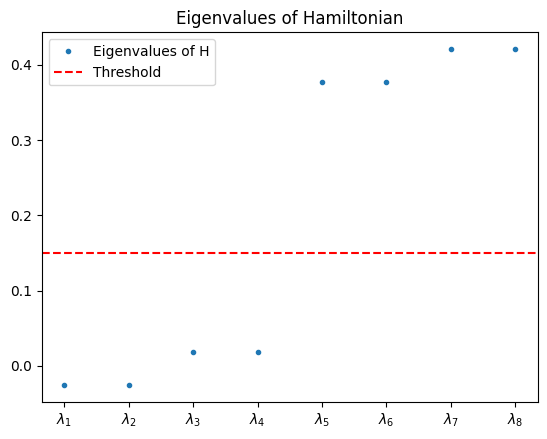

In [40]:
λ, v = np.linalg.eigh(H)
plt.plot(λ, ".", label="Eigenvalues of H")
plt.axhline(y = 0.15, color = "r", linestyle = "dashed", label="Threshold")    
plt.xticks(np.arange(len(λ)), ["$\lambda_" + str(i+1) + "$" for i in range(len(λ))])
plt.legend(loc="upper left")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

The eigenstate filtering can be realized by applying the eigenvalues to a step-function that evaluates to one if the input is below the threshold and zero otherwise. However, since the step-function has neither odd or even parity, we need to consider an symmetrized version instead. We can calculate the respective phase angles using the [pyqsp package](https://github.com/ichuang/pyqsp)
.

[pyqsp.poly.PolyEfilter] degree=30, delta=0.3
[PolyTaylorSeries] max [0.94955034] is at [2.19000128e-08]: normalizing
[PolyTaylorSeries] average error = 0.009629178075583878 in the domain [-1, 1] using degree 30


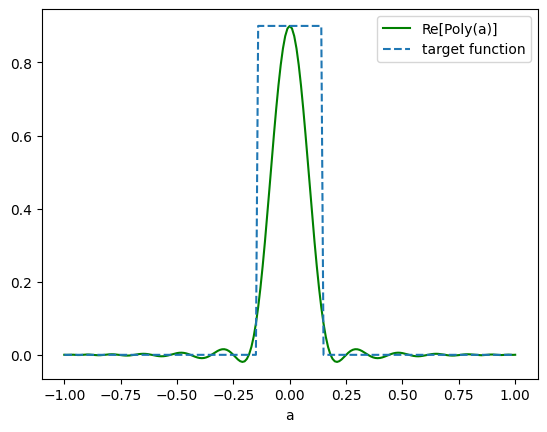

In [41]:
import pyqsp
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

pg = pyqsp.poly.PolyEigenstateFiltering()
pcoeffs, scale = pg.generate(30, 0.3, ensure_bounded=True, return_scale=True)
ang_seq = QuantumSignalProcessingPhases(pcoeffs, signal_operator="Wz")
d = len(ang_seq) - 1
ang_seq_QEVT = ang_seq - phase_diff(d)

poly_filt = np.polynomial.Polynomial(pcoeffs)
poly_filt.degree()

a_list = np.linspace(-1, 1, 201)
plt.plot(a_list, poly_filt(a_list), "g", label="Re[Poly(a)]")


def target_filt(x, delta, scale=1):
    """
    Target function for eigenvalue filtering.
    """
    return scale * (np.sign(x + 0.5*delta) - np.sign(x - 0.5*delta)) / 2

plt.plot(a_list, target_filt(a_list, 0.3, scale=0.9), "--", label="target function")
plt.xlabel("a")
plt.legend(loc="upper right")

After applying the QEVT, we can see that the eigenvalues of the transformed matrix are just as expected:

λ: [ 0.95115064-0.j  0.94911373-0.j  0.8728914 -0.j  0.85758775-0.j
 -0.00131123+0.j -0.01097495+0.j -0.0795625 +0.j -0.10250956+0.j]


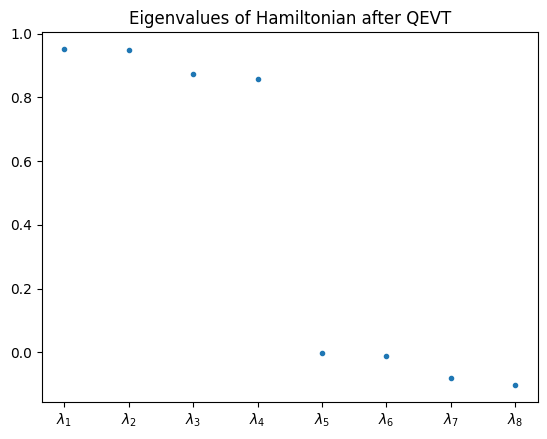

In [42]:
# apply QEVT
Poly_H = QEVT(ang_seq_QEVT, H)[0:8, 0:8]

# calculate eigenvalues
λ, v = np.linalg.eigh(Poly_H)

# apply global phase
λ = λ*((-1j)**(len(ang_seq)-1))

plt.plot(λ, ".")
plt.xticks(np.arange(len(λ)), ['$\lambda_' + str(i+1) + '$' for i in range(len(λ))]) 
plt.title("Eigenvalues of Hamiltonian after QEVT")
plt.show()

# Quantum Singular Value Transformation
In the case of the QSVT, the simplifying assumptions of the QEVT no longer hold.
First of all, the matrix to transform does not necessarily have to be square which means that more sophisticated block-encodings might be required.

<img src="./images/QSVT_circuit.svg" alt="circuit of the QSVT" width=50%>

References
==========

<a id="grand_unification">[1]</a>:
    John M. Martyn, Zane M. Rossi, Andrew K. Tan, and Isaac L. Chuang,
    \"Grand Unification of Quantum Algorithms\", [PRX Quantum 2,
    040203](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203),
    2021

<a id="qsvt">[2]</a>:
    András Gilyén, Yuan Su, Guang Hao Low, Nathan Wiebe, \"Quantum
    singular value transformation and beyond: exponential improvements
    for quantum matrix arithmetics\", [Proceedings of the 51st Annual
    ACM SIGACT Symposium on the Theory of
    Computing](https://dl.acm.org/doi/abs/10.1145/3313276.3316366), 2019

<a id="pennylane_tutorial">[3]</a>:
    Juan Miguel Arrazola,
    \"Intro to QSVT\",
    https://pennylane.ai/qml/demos/tutorial_intro_qsvt, 2023

<a id="qsp_angles">[4]</a>:
   Rui Chao, Dawei Ding, András Gilyén, Cupjin Huang, and Mario Szegedy,
    \" Finding Angles for Quantum Signal Processing with Machine Precision\",
    [arXiv Preprint arXiv:2003.02831](https://arxiv.org/abs/2003.02831), 2020 